In [32]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
sns.set(style='ticks')
import folium
from folium import Marker, GeoJson
from folium.plugins import HeatMap
import geopandas as gpd
import json, os, gzip, random,math
import shapely.geometry

import numpy as np
from copy import deepcopy
from sklearn import linear_model
from sklearn.metrics import mean_squared_error,r2_score
import scipy.stats
from scipy.optimize import curve_fit

# Function for displaying the map
def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')


### First, we process the sample twitter data form cdmx in order to get a clean geopandas dataframe with tweets coordinates.

In [6]:
files = os.listdir("sample_cdmxtweets/")

multi_dataframes=[]
for somefile in files:
    with gzip.open("sample_cdmxtweets/"+somefile,"r") as f:
        data_obj = json.load(f)
        df_tweets = pd.DataFrame(data = data_obj) 
        new_dict={}
        new_dict["coordinates"] = [tuple(d.values())[-1] for d in df_tweets.coordinates]
        df_coordinates = pd.DataFrame(data=new_dict)
        long = [ x[0] for x in df_coordinates.iloc[:,0]]
        lat = [ x[1] for x in df_coordinates.iloc[:,0]]
        df_coordinates = pd.DataFrame(data={"Longitude":long,"Latitude":lat})
        multi_dataframes.append(df_coordinates)

all_df_coordinates = pd.concat(multi_dataframes)
all_df_coordinates.reset_index(drop=True,inplace=True)

In [19]:

#create geo-coordinates dataframe from tweets
df_coordinates_gdf = gpd.GeoDataFrame(all_df_coordinates,geometry=\
                                     gpd.points_from_xy(all_df_coordinates.Longitude,all_df_coordinates.Latitude))
df_coordinates_gdf.crs = {'init': 'epsg:4326'} # set coordinate reference system


centermex=(-99.133217,19.432777) #long,lat, Mexico's center
centeruk = (-0.118092,51.509865) #long, latitud of UK's center
centers=[centermex,centeruk]

gdf= gpd.GeoDataFrame(coord_centros['Mex'],geometry =\
                       gpd.points_from_xy(coord_centros['Mex'].Longitude,coord_centros['Mex'].Latitude),\
                      crs ={'init' :'epsg:4326'} )

In [20]:
gdf

,Longitude,Latitude,geometry
0,-99.133217,19.432777,POINT (-99.13322 19.43278)


### In order to get a consistent distance from the center of the buffer, we must define an azimuthal equidistant projection.

In [21]:
lat,long = gdf.Latitude[0],gdf.Longitude[0]
proj4_txt = "+proj=aeqd +lat_0="+ str(lat) +" +lon_0="+ str(long) +" +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs" 
gdf=gdf.to_crs(proj4_txt)

dist4country = { "Mexico":np.arange(0,11), "United_Kingdom":np.arange(0,10)}
base=2
distancias = np.power(base, dist4country['Mexico']).astype(float)*3*1000 #buffer's radius in meters.

In [17]:
two_mile_buffer = gdf.geometry.buffer(distance=distancias[2]) # 12 km radius

### We can now embed the map as an html file.

In [18]:
m = folium.Map(location=[gdf.Latitude, gdf.Longitude],zoom_start=11)

mc = folium.plugins.MarkerCluster()
for idx, row in df_coordinates_gdf.iterrows():
    if not math.isnan(row['Longitude']) and not math.isnan(row['Latitude']):
        mc.add_child(Marker([row['Latitude'], row['Longitude']]))
m.add_child(mc)

GeoJson(two_mile_buffer.to_crs(epsg=4326)).add_to(m)
embed_map(m,"m1.html")

### Number of tweets vs radius of geospatial buffers

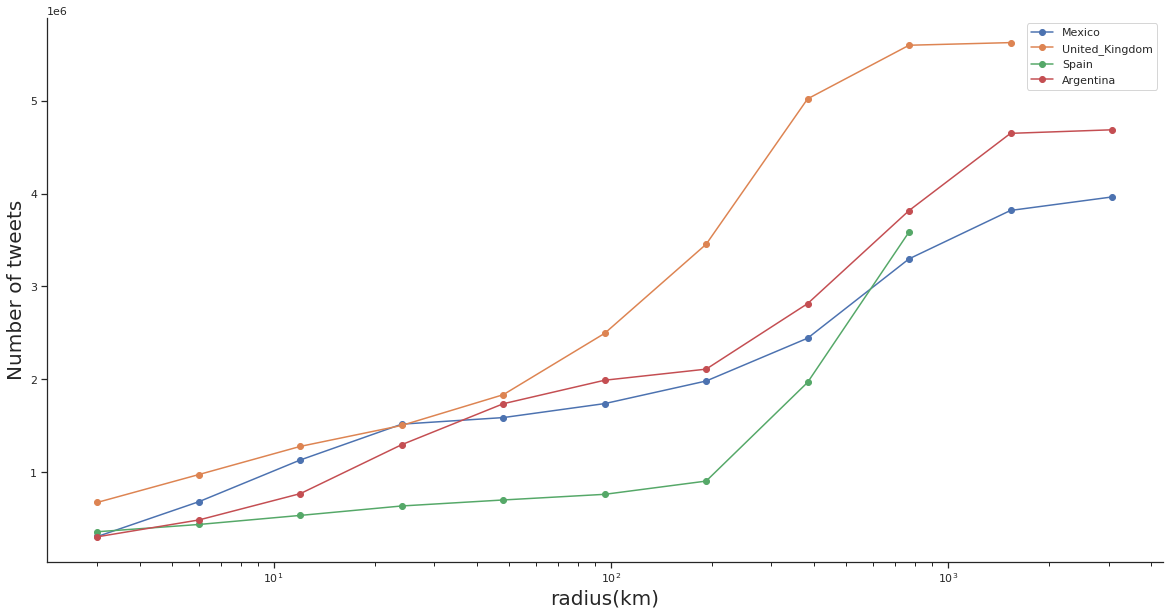

In [2]:
def num_tweets_vsdistancia(country):
    max_tweets = pd.read_csv(f'{country}_data.csv')
    return max_tweets

countries = ["Mexico", "United_Kingdom","Spain","Argentina"]
fig,axs = plt.subplots(figsize=(20,10))
for i,country in enumerate(countries):
    data=num_tweets_vsdistancia(country)
    axs.plot(data.iloc[:,0],data.iloc[:,1],label=f'{country}',marker='o')
    axs.set_xscale('log')
    axs.legend()
    axs.set_xlabel('radius(km)',fontsize=20)
    axs.set_ylabel('Number of` tweets',fontsize=20)
    axs.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
sns.despine()
# plt.savefig('tweetsvsradius.pdf')

### The plots below show that the rank diversity distributions obtained from twitter data are consistent with the hypotesis of following a lognormal cumulative distributions with parameters $\mu$, $\sigma$.

$$\Phi(log_{10}k;\mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\int_{-\infty}^{log_{10}k} e^{\frac{(y-\mu)^2}{2\sigma^2}}dy $$

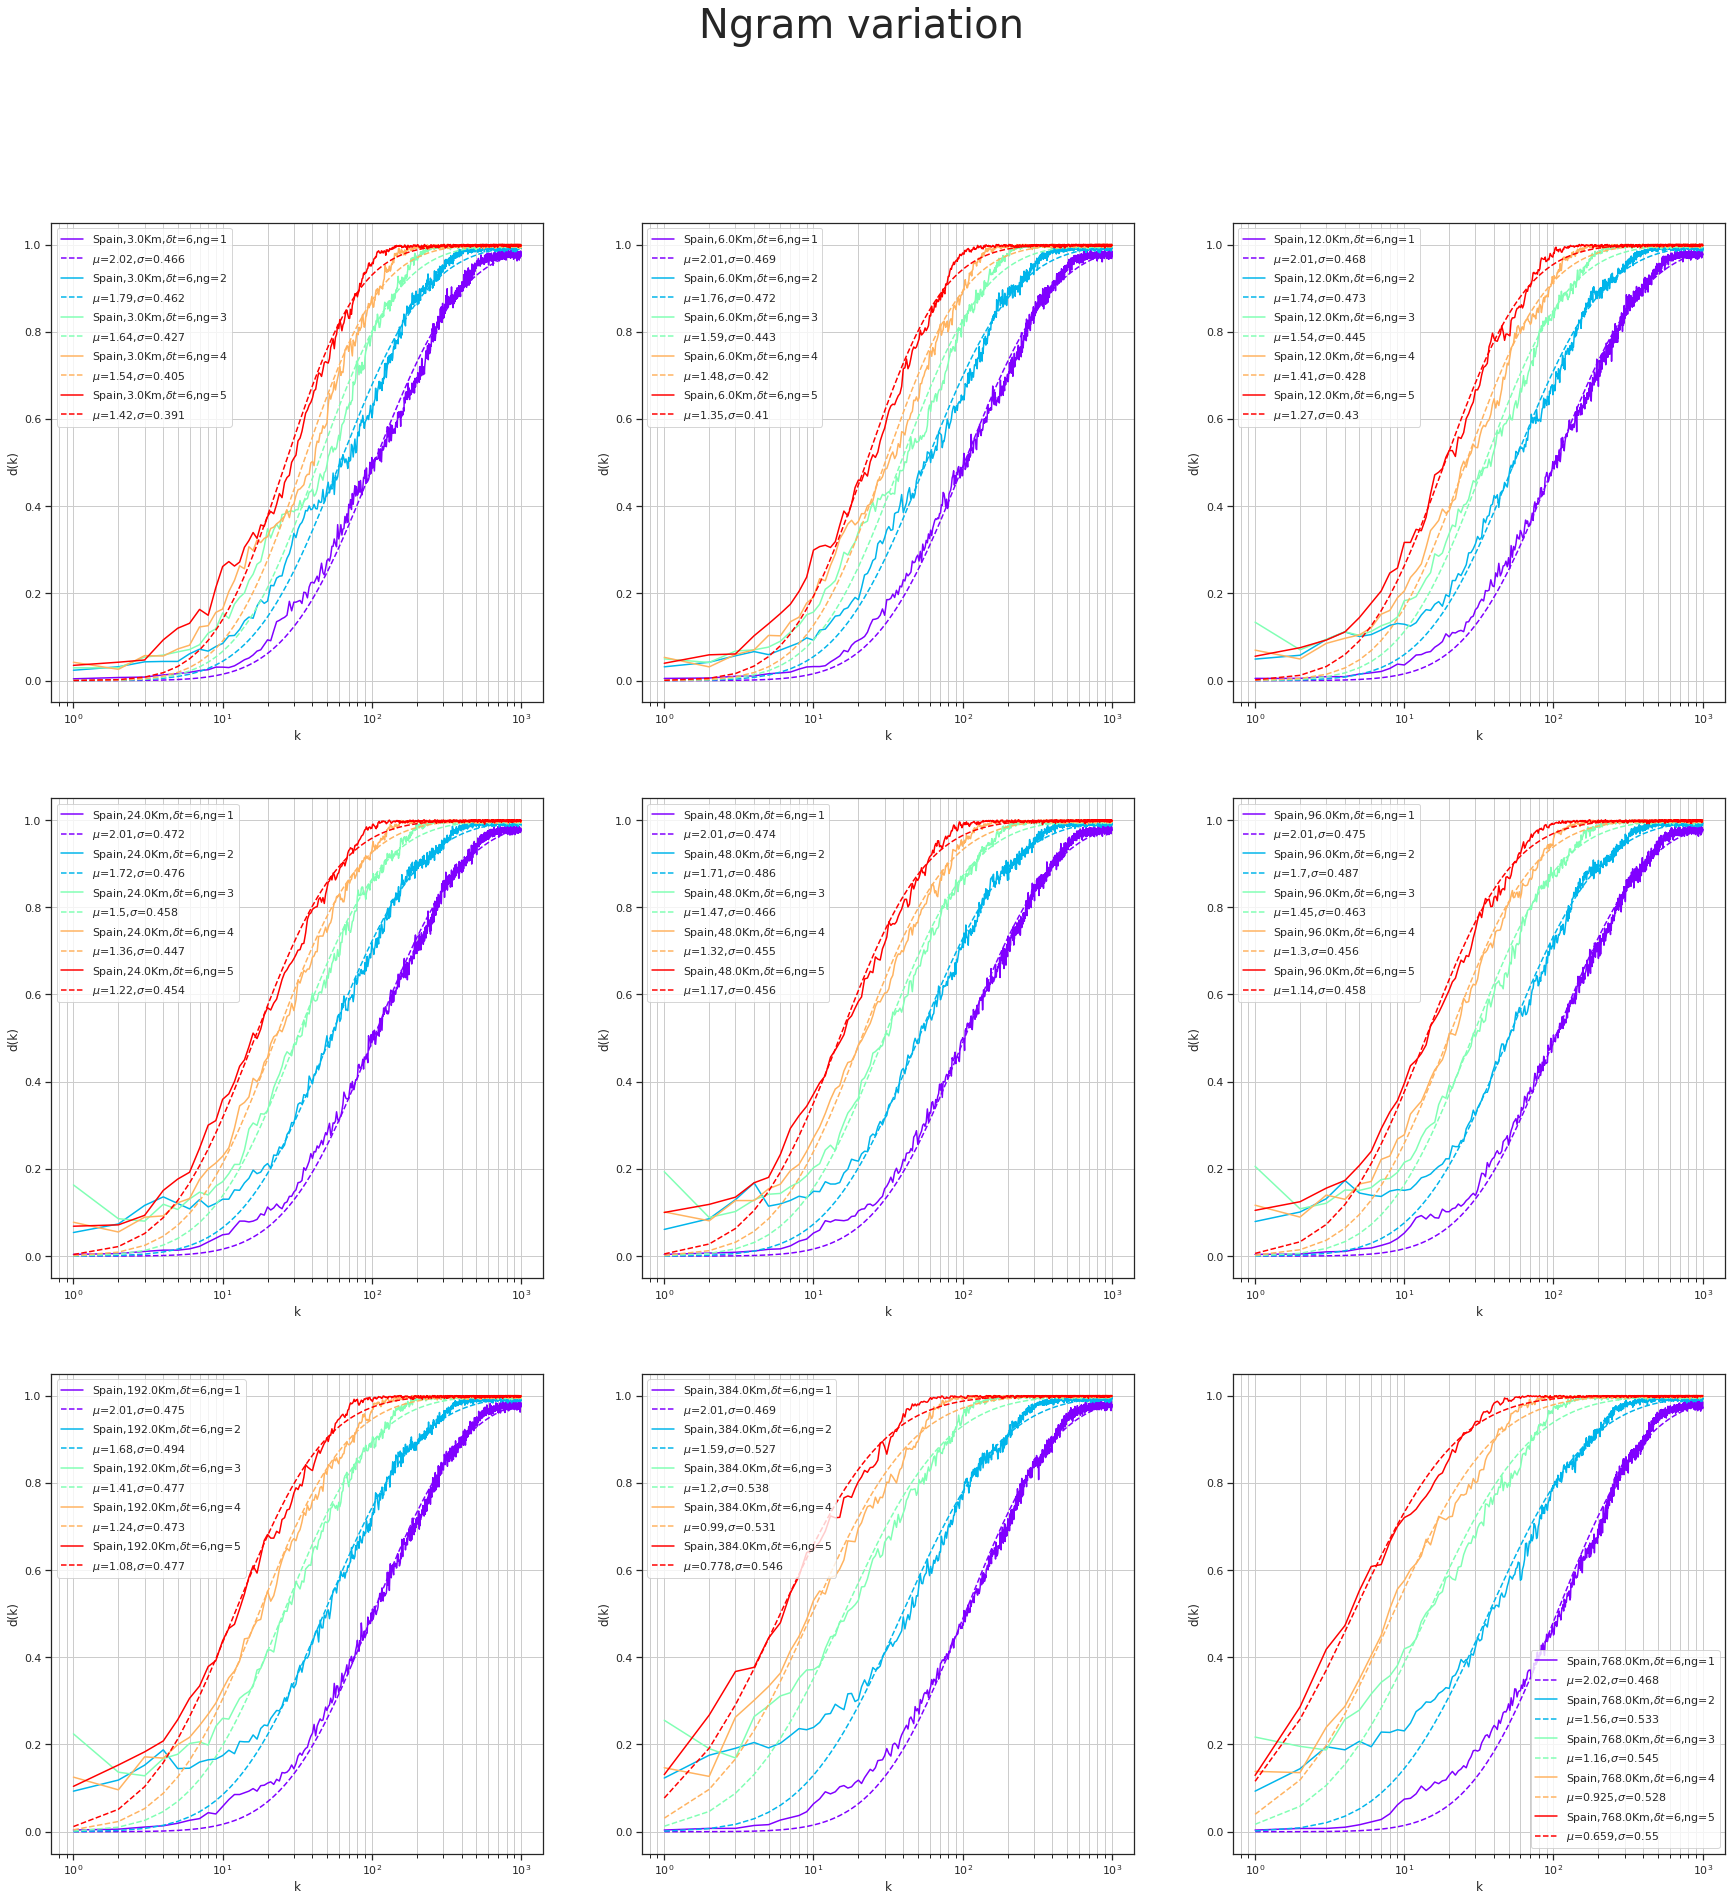

In [46]:
prepath = '../Datos_todoslosPaises/'

#Lognormal cumulative distribution definition
def EvalnormCdf(x,mu,sigma):
    return scipy.stats.norm.cdf(np.log10(x),loc=mu,scale=sigma)

def ajuste(data_fit,funcion):
    X = data_fit[:,0]
    Y = data_fit[:,1]
    param_model, pcov1 = curve_fit(funcion,X,Y)
    return param_model

def plotRD(country,level,ngrams,timeint,totalgrams,color,ax=None):
    """ Plot rank diversity using 4 different parameters 
    Input: 
    Country (str)<- Mexico,United_Kingdom
    level (int) <- (0,1,2,3,4,5,6,7,8,9,10)
    ngrams (int) <- (1,2,3,4,5)
    timeint (int) <- (3,6,12,24,48,96)
    """
    path = prepath+'{}/Level_{}/results_{}grams/{}hour_{}grams_RD.txt'.format(country,level,totalgrams,timeint,ngrams)
    dist4country = { "Mexico":np.arange(0,11), "United_Kingdom":np.arange(0,10),"Spain":np.arange(0,9),"India":np.arange(0,11),'Argentina':np.arange(0,11)}
    base=2
    distancias = np.power(base, dist4country[country]).astype(float)*3*1000 #definicion de distancias en km.
    data = np.loadtxt(path)
    
    if not ax:
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(1,1,1)
        ax.set_title("{},{}Km,ngrams={},timeint={}".format(country,distancias[level]/1000,ngrams,timeint))
        ax.grid(which='both')

    ax.plot(data[:,0],data[:,1],c=color,label='{},{}Km,$\delta t$={},ng={}'.format(country,distancias[level]/1000,timeint,ngrams))
    ax.set_xlabel("$k$")
    ax.set_ylabel('d(k)')
    ax.set_xscale('log')

def plotnormCdfFit(country,level,ngrams,timeint,totalgrams,color,ax=None):
    path = prepath+'{}/Level_{}/results_{}grams/{}hour_{}grams_RD.txt'.format(country,level,totalgrams,timeint,ngrams)
    data = np.loadtxt(path)
    parametros = ajuste(data,EvalnormCdf)
    
    if not ax:
        fig = plt.figure(figsize=(10,7))
        ax = fig.add_subplot(1,1,1)
        ax.grid(which='both')
    ax.plot(data[:,0],EvalnormCdf(data[:,0],*parametros),'--',c=color,label="$\mu$={:.3},$\sigma$={:.3}".format(*parametros))
    ax.set_xlabel("k")
    ax.set_ylabel('d(k)')
    ax.set_xscale('log')

NGRAMS = [1,2,3,4,5]
# TIME = [3,6,12,24,48,96]
TIME = [6]
# countries = ["Mexico", "United_Kingdom","Spain","India"]
countries = ["Spain"]

totalgrams = 1000

for country in countries:
    dist4country = { "Mexico":np.arange(0,11), "United_Kingdom":np.arange(0,10),"Spain":np.arange(0,9),"India":np.arange(0,11),'Argentina':np.arange(0,11)}
    SPATIAL = dist4country[country]
            
    ##Displaying ngrams variation
    
    for timeint in TIME:
        fig,axs = plt.subplots(ncols=3,nrows=3,figsize=(30,30))
        axs = axs.ravel()
        for level,ax in zip(SPATIAL,axs):
            color = iter(cm.rainbow(np.linspace(0,1,len(NGRAMS))))
            for ngram in NGRAMS:
                c = next(color)
                plotRD(country,level,ngrams=ngram,timeint=timeint,ax=ax,totalgrams=totalgrams,color=c)
                try:
                    plotnormCdfFit(country,level,ngrams=ngram,timeint=timeint,totalgrams=totalgrams,ax=ax,color=c)
                except RuntimeError:
                    pass

            ax.grid(which="both")
            ax.legend()
        plt.suptitle('Ngram variation',fontsize=40)